sbppc:

https://github.com/ysBach/sbppc

Small-Body Polarization Phase Curve fitting tools.

In [1]:
%load_ext version_information
import time
now = time.strftime("%Y-%m-%d %H:%M:%S (%Z = GMT%z)")
print(f"This notebook was generated at {now} ")

vv = %version_information scipy, numpy, matplotlib, pandas, astropy, corner, emcee, version_information
for i, pkg in enumerate(vv.packages):
    print(f"{i} {pkg[0]:10s} {pkg[1]:s}")

This notebook was generated at 2023-12-12 15:09:04 (KST = GMT+0900) 
0 Python     3.10.13 64bit [Clang 16.0.6 ]
1 IPython    8.15.0
2 OS         macOS 13.1 arm64 arm 64bit
3 scipy      1.11.2
4 numpy      1.25.2
5 matplotlib 3.8.0
6 pandas     2.1.1
7 astropy    5.3.4
8 corner     2.0.2.dev0
9 emcee      3.1.4
10 version_information 1.0.4


In [2]:
from itertools import product
from pathlib import Path

import corner
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from scipy.integrate import trapezoid
from scipy.interpolate import interp1d
from astropy.stats import sigma_clip
from scipy.stats import chi2

import emcee
import sbppc

# %matplotlib notebook
%config InlineBackend.figure_format = 'retina'
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'last_expr'

# We need to do it in a separate cell. See:
# https://github.com/jupyter/notebook/issues/3385
plt.style.use('default')
plt.rcParams.update({
    'font.family': 'latin modern math', 'font.size':12, 'mathtext.fontset':'stix',
    'axes.formatter.use_mathtext': True, 'axes.formatter.limits': (-4, 4),
    'axes.grid': False, 'grid.color': 'gray', 'grid.linewidth': 0.5,
    'xtick.top': True, 'ytick.right': True,
    'xtick.direction': 'inout', 'ytick.direction': 'inout',
    'xtick.minor.size': 2.0, 'ytick.minor.size': 2.0,  # default 2.0
    'xtick.major.size': 4.0, 'ytick.major.size': 4.0,  # default 3.5
    'xtick.minor.visible': True, 'ytick.minor.visible': True
})

df_filt = pd.read_excel("extdata/_nic_filter_information/data060606_nhao.xls", sheet_name="data")
df_dawnfilt = pd.read_csv("extdata/Dawn_FC.F1.dat", names=["wlen", "prof"], sep="\s+").sort_values("wlen").reset_index(drop=True)
df_refl_ceres = pd.read_csv("extdata/a000001.sp41.txt", names=["wlen", "r", "dr", "n"], sep="\s+")
df_refl_vesta = pd.read_csv("extdata/a000004.sp86.txt", names=["wlen", "r", "dr", "n"], sep="\s+")
df_refl_ceres = df_refl_ceres.loc[df_refl_ceres["n"] != 0].copy()
df_refl_vesta = df_refl_vesta.loc[df_refl_vesta["n"] != 0].copy()

df_pol = pd.read_csv("results/df_fin.csv")
df_pol = df_pol.loc[df_pol["rapmode"]=="min"].copy().reset_index()

df_apd = pd.read_csv("extdata/apd_df.csv")
df_apd = df_apd.loc[df_apd["filter"] != "R2"].copy()

# additional data for Ceres and Vesta
_df_cellino = pd.read_csv("extdata/Cellino+2016.csv").drop(columns=["LatSE", "LongSE", "pV"])
_df_cellino2 = {'Pr':[], 'dpol':[], 'alpha':[], 'date':[], 'date_frac':[], 'observatory':[], 'reference':[], 'filter':[]}
for (date, filt), g in _df_cellino.groupby(["date", "filter"]):
    _polr = g["Pr"]
    _polr_ma = sigma_clip(_polr, sigma=3, maxiters=5, cenfunc="median")
    num = np.sum(~_polr_ma.mask)

    _df_cellino2["Pr"].append(np.ma.median(_polr_ma))
    _df_cellino2["dpol"].append(np.ma.std(_polr_ma, ddof=1)/np.sqrt(num))
    for c in ["alpha", "filter", "date", "date_frac", "observatory", "reference"]:
        _df_cellino2[c].append(g[c].iloc[0])
_df_cellino = pd.DataFrame.from_dict(_df_cellino2)
# wavelengths match with Lupishko APD v2...
_df_cellino["wlen"] = _df_cellino["filter"].map(dict(B=0.435, V=0.559))
_df_cellino["num"] = 4
_df_cellino["name"] = "Vesta"

_df_bend = pd.read_csv("extdata/Bendjoya+2022.csv", skiprows=1,
                      names=["num", "jd", "date_frac", "alpha", "Pr", "dpol", "filter"])
_df_bend["jd"] = _df_bend["jd"] + _df_bend["date_frac"]
_df_bend["name"] = _df_bend["num"].map({1:"Ceres", 4:"Vesta"})
_df_bend["reference"] = "2022A&A...665A..66B"
# wavelengths match with Lupishko APD v2... (except I)
_df_bend["wlen"] = _df_bend["filter"].map(dict(U=0.362, B=0.435, V=0.559, R=0.635, I=0.783))

df_apd = pd.concat([df_apd, _df_bend, _df_cellino])
df_apd.to_csv("extdata/apd_ceres_vesta_all.csv", index=False)

NCHAIN = 32
RS = np.random.RandomState(1414)  # asteroids 1 and 4

df_mas22 = pd.DataFrame.from_dict(dict(
    objname=["Ceres"]*4, filt=list("JHJH"), alpha=[21., 21., 8.3, 8.3],
    Pr=[0.84, 0.88, -1.74, -1.61], dPr=[0.02, 0.02, 0.02, 0.03],
    thetar=[157.7, 163.8, 83.4, 86.6], dthetar=[0.5, 0.2, 0.1, 0.1],
    ref=["Mas+22"]*4, index=999
))
df_pol["ref"] = "this"
df_pol = pd.concat([df_pol, df_mas22])

## MCMC

Using ``emcee``

In [3]:
samples_masked = dict()
taus = dict()
popts = dict()
errs = dict()
chi2mins = dict()
flatkw = dict(discard=1000, thin=1, flat=True)


for i, obj in enumerate(["Ceres", "Vesta"]):
    for filt, color in zip("JHK", ["royalblue", "orange", "salmon"]):
        _df = df_pol.loc[(df_pol.filt==filt) & (df_pol.objname==obj)]
        alpha = _df["alpha"].to_numpy()
        Pr = _df["Pr"].to_numpy()
        dPr = _df["dPr"].to_numpy()
        ppc = sbppc.PPCModel("le")
        _ = ppc.solve_lsq(alpha, Pr, dPr)

        # Set up the backend
        # Don't forget to clear it in case the file already exists
        h5path = Path(f"emcee/emcee_{obj}_{filt}.h5")
        h5path.parent.mkdir(parents=True, exist_ok=True)
        if not h5path.exists():
            pos = ppc.theta_lsq + 1e-4 * RS.randn(NCHAIN, len(ppc.theta_lsq))
            backend = emcee.backends.HDFBackend(h5path)
            backend.reset(*pos.shape)
            sampler = emcee.EnsembleSampler(
                *pos.shape, log_prob_fn=ppc.log_prob_fn, args=(alpha, Pr, dPr), backend=backend
            )
            sampler.run_mcmc(pos, 3000, progress=False);
        else:
            sampler = emcee.backends.HDFBackend(h5path)

        tau = sampler.get_autocorr_time()

        df_samples = pd.DataFrame.from_records(sampler.get_chain(**flatkw), columns=["h", "a0", "k"])
#         chi2s = np.zeros(len(df_samples), dtype=float)
#         calc_chi2(df_samples.values, alpha, Pr, dPr, chi2s)
        df_samples["chi2"] = -2*sampler.get_log_prob(**flatkw)
        df_samples["amin"] = sbppc.alpha_min_le(h=df_samples.h, a0=df_samples.a0, k=df_samples.k)
        df_samples["Pmin"] = sbppc.ppc_le(df_samples.amin, h=df_samples.h, a0=df_samples.a0, k=df_samples.k)

        # discard some outliers to make corner plot pretty... (±5-σ)
        mask = np.ones(len(df_samples)).astype(bool)
        for par in ["h", "a0", "k"]:
            pct = np.percentile(df_samples[par], [16, 84])
            med = np.median(df_samples[par])
            mask &= (5*pct[0]-4*med <= df_samples[par]) & (df_samples[par] <= 5*pct[1]-4*med)
        print("n_rejected: ", len(df_samples) - np.count_nonzero(mask))
        df_masked = df_samples.loc[mask].copy()
#         sigma_factor=  np.sqrt(2 / (len(alpha) - len(THETA_0)))
#         df_samples = df_samples.sort_values("chi2").reset_index(drop=True)
#         df_masked = df_samples.loc[df_samples["chi2"] < df_samples.loc[0, "chi2"] *(1 + sigma_factor)]
        df_masked = df_masked.sort_values("chi2").reset_index(drop=True)
        popt = df_masked.iloc[0][['h', 'a0', 'k', 'amin', 'Pmin']].values

        taus[obj, filt] = tau
        samples_masked[obj, filt] = df_masked
        popts[obj, filt] = popt
        chi2mins[obj, filt] = df_masked.loc[0, "chi2"]
        print(f"{obj}, {filt} ({tau}): {popt} ")

        # Corner plots
        outfile = Path(f"results/figs-mcmc/corner-{obj}_{filt}.pdf")
        if outfile.exists():
            continue
        fig = corner.corner(
            df_masked[["h", "a0", "k", "amin", "Pmin"]].values,
            labels=[r"$k ~[°]$", r"$h ~[\%/°]$", r"$α_0 ~[°]$", r"$α_\mathrm{min}$", r"$P_\mathrm{min}$"],
            truths=df_masked.loc[0, ["h", "a0", "k", "amin", "Pmin"]], bins=40,
#             quantiles=(0.16, 0.5, 0.84),
            levels=(1 - np.exp(-0.5*np.arange(1, 4)**2)),
            title_quantiles=[0.16, 0.50, 0.84],
            title_fmt="5.4f", show_titles=True,
            contour_kwargs=dict(linewidths=0.5)
        )
        corner.overplot_lines(fig, df_masked[["h", "a0", "k", "amin", "Pmin"]].quantile().values, color="k", ls="--", lw=1)
        corner.overplot_lines(fig, df_masked[["h", "a0", "k", "amin", "Pmin"]].quantile(0.16).values, color="k", ls="--", lw=1)
        corner.overplot_lines(fig, df_masked[["h", "a0", "k", "amin", "Pmin"]].quantile(0.84).values, color="k", ls="--", lw=1)
        plt.suptitle("16-50-84 Percentiles in Dashed Lines and Titles\nBlue Solid Lines for Least-Square Solutions")
        plt.savefig(f"results/figs-mcmc/corner-{obj}_{filt}.pdf", dpi=300)
        plt.clf()
        plt.close("all")


n_rejected:  4
Ceres, J ([36.17546681 35.66944905 37.0579546 ]): [ 0.25699163 17.79608532  6.54357319  6.99289497 -1.75383493] 
n_rejected:  1
Ceres, H ([35.58226039 36.2681743  38.6239331 ]): [ 0.25667555 17.71688999  7.727549    7.23447339 -1.64050061] 
n_rejected:  401
Ceres, K ([44.67408572 42.04509721 49.56964378]): [ 0.30082753 17.46360445 13.08731463  7.77484534 -1.6355148 ] 
n_rejected:  39
Vesta, J ([38.38843231 37.51863065 38.4502982 ]): [ 0.05883556 22.72202664  4.12351014  7.05401814 -0.70032801] 
n_rejected:  78
Vesta, H ([42.78300198 39.10716903 44.73978911]): [ 0.08205399 23.25857821  6.28313054  8.38041208 -0.83143227] 
n_rejected:  29
Vesta, K ([33.52945737 34.56060843 34.45407   ]): [ 0.09054279 23.9639469   5.06734039  7.91826704 -1.05794266] 


### Table for TeX
Copy-and-Paste this to the LaTeX:

In [4]:
print(r"""
\begin{table*}
\caption{Polarimetric data reduction results. $n$: Number of used polarimetric data sets after data filtering and outlier rejections (one set corresponds to four exposures, see Appendix), $\alpha$: Solar phase angle, $P$ \& $dP$: The total polarization degree and its uncertainty, $\theta_P$ \& $d\theta_P$: The position angle of the strongest electric vector and its uncertainty, $\polr$ \& $d\polr$: The proper polarization degree referring to the scattering plan and its uncertainty, and $\theta_\mathrm{r}$: Position angle of the strongest electric vector, with respect to the scattering plane normal vector.}
\label{tab: res-pol}
\centering
\begin{tabular}{lccccccccc}
\hline\hline
Object & Filter & $n$ & $\alpha$ & $P$ & $\theta_P$ & $\polr$ & $d\polr$ & $\theta_\mathrm{r}$ & $d\theta_\mathrm{r}$ \\
  & & & $\degr$ & \% & $\degr$ & \% & \% & $\degr$ & $\degr$ \\
\hline""")
for objname, filt in product(["Ceres", "Vesta"], "JHK"):
    _df = df_pol.loc[(df_pol["objname"]==objname) & (df_pol["filt"]==filt)].sort_values("alpha")
    _df["thetar"] = (_df["thetar"] + 90) % 180 - 90              # to [-180, +180)
    for _, row in _df.iterrows():
        filt = r"\Ks" if row.filt=="K" else row.filt
        _obj = objname if row.ref=="this" else f"\\textit{{{objname}}}\\tablefootmark{{a}}"
        num = "$ - $" if np.isnan(row.nused) else f"{row.nused:3.0f}"
        pval = "$  -  $" if np.isnan(row.P) else f"${row.P:5.3f}$"
        tval = "$   -  $" if np.isnan(row.thetaP) else f"${row.thetaP:+6.2f}$"
        prval = f"${row.Pr:+6.3f}$ & ${row.dPr:5.3f}$"
        trval = f"${row.thetar:6.2f}$ & ${row.dthetar:5.2f}$"
        print(" & ".join([_obj, f"{filt:3s}", num, f"${row.alpha:4.1f}$", pval, tval, prval, trval]),
              r"\\")
    print(r"\hline")
print(r"""\end{tabular}
\tablefoot{\tablefoottext{a}{Data from \cite{2022PSJ.....3...90M}.}}
\end{table*}""")


\begin{table*}
\caption{Polarimetric data reduction results. $n$: Number of used polarimetric data sets after data filtering and outlier rejections (one set corresponds to four exposures, see Appendix), $\alpha$: Solar phase angle, $P$ \& $dP$: The total polarization degree and its uncertainty, $\theta_P$ \& $d\theta_P$: The position angle of the strongest electric vector and its uncertainty, $\polr$ \& $d\polr$: The proper polarization degree referring to the scattering plan and its uncertainty, and $\theta_\mathrm{r}$: Position angle of the strongest electric vector, with respect to the scattering plane normal vector.}
\label{tab: res-pol}
\centering
\begin{tabular}{lccccccccc}
\hline\hline
Object & Filter & $n$ & $\alpha$ & $P$ & $\theta_P$ & $\polr$ & $d\polr$ & $\theta_\mathrm{r}$ & $d\theta_\mathrm{r}$ \\
  & & & $\degr$ & \% & $\degr$ & \% & \% & $\degr$ & $\degr$ \\
\hline
\textit{Ceres}\tablefootmark{a} & J   & $ - $ & $ 8.3$ & $  -  $ & $   -  $ & $-1.740$ & $0.020$ & $ 83.4

In [5]:
df_fit = pd.DataFrame.from_dict(popts).T.reset_index()
df_fit.columns = ["object", "filt", "h", "a0", "k", "amin", "Pmin"]
_ksfilt = r"\Ks"
for par in ["h", "a0", "k", "amin", "Pmin"]:
    df_fit[f"d{par}"] = None
    df_fit[f"D{par}"] = None
    df_fit[f"d{par}_med"] = None
    df_fit[f"{par}_med"] = None
    df_fit[f"D{par}_med"] = None

for i, row in df_fit.iterrows():
    obj, filt = row["object"], row["filt"]
    par_strs_ls = []
    par_strs_mc = []
    for par, fmt in zip(["h", "a0", "k", "amin", "Pmin"],
                        [".4f", ".2f", ".3f", ".2f", ".3f"]):
        lo, med, hi = np.percentile(samples_masked[obj, filt][par], [16, 50, 84])
        dlo = np.abs(row[par] - lo)
        dhi = np.abs(hi - row[par])
        dlo_m = np.abs(med - lo)
        dhi_m = np.abs(med - hi)
        df_fit.loc[i, f"d{par}"] = dlo
        df_fit.loc[i, f"D{par}"] = dhi
        df_fit.loc[i, f"d{par}_med"] = dlo_m
        df_fit.loc[i, f"{par}_med"] = med
        df_fit.loc[i, f"D{par}_med"] = dhi_m
        par_strs_ls.append(f"${row[par]:{fmt}}^{{+{dhi:{fmt}}}}_{{-{dlo:{fmt}}}}$")
        par_strs_mc.append(f"${med:{fmt}}^{{+{dhi_m:{fmt}}}}_{{-{dlo_m:{fmt}}}}$")
    print(f"{obj} & {_ksfilt if filt=='K' else filt} & LS & " + " & ".join(par_strs_ls) + r"\\")
    print(f"{obj} & {_ksfilt if filt=='K' else filt} & MC & " + " & ".join(par_strs_mc) + r"\\")


Ceres & J & LS & $0.2570^{+0.0043}_{-0.0042}$ & $17.80^{+0.06}_{-0.05}$ & $6.544^{+0.522}_{-0.435}$ & $6.99^{+0.14}_{-0.13}$ & $-1.754^{+0.025}_{-0.023}$\\
Ceres & J & MC & $0.2570^{+0.0043}_{-0.0042}$ & $17.80^{+0.06}_{-0.06}$ & $6.562^{+0.504}_{-0.453}$ & $7.00^{+0.13}_{-0.14}$ & $-1.753^{+0.024}_{-0.024}$\\
Ceres & H & LS & $0.2567^{+0.0061}_{-0.0047}$ & $17.72^{+0.07}_{-0.06}$ & $7.728^{+0.967}_{-0.628}$ & $7.23^{+0.19}_{-0.14}$ & $-1.641^{+0.031}_{-0.027}$\\
Ceres & H & MC & $0.2573^{+0.0055}_{-0.0053}$ & $17.72^{+0.07}_{-0.07}$ & $7.831^{+0.864}_{-0.731}$ & $7.26^{+0.16}_{-0.17}$ & $-1.638^{+0.029}_{-0.030}$\\
Ceres & \Ks & LS & $0.3008^{+0.0126}_{-0.0064}$ & $17.46^{+0.13}_{-0.07}$ & $13.087^{+6.304}_{-1.567}$ & $7.77^{+0.35}_{-0.14}$ & $-1.636^{+0.057}_{-0.029}$\\
Ceres & \Ks & MC & $0.3040^{+0.0095}_{-0.0095}$ & $17.50^{+0.10}_{-0.10}$ & $14.562^{+4.829}_{-3.042}$ & $7.88^{+0.24}_{-0.25}$ & $-1.621^{+0.042}_{-0.044}$\\
Vesta & J & LS & $0.0588^{+0.0098}_{-0.0075}$ & $22.72^{+0

In [6]:
for i, row in df_fit.iterrows():
    obj, filt = row["object"], row["filt"]
    par_strs_ls = []
    par_strs_mc = []
    for par, fmt in zip(["h", "a0", "k", "amin", "Pmin"],
                        [".4f", ".2f", ".3f", ".2f", ".3f"]):
        lo, med, hi = np.percentile(samples_masked[obj, filt][par], [16, 50, 84])
        dlo = np.abs(row[par] - lo)
        dhi = np.abs(hi - row[par])
        dlo_m = np.abs(med - lo)
        dhi_m = np.abs(med - hi)
        par_strs_ls.append(f"${row[par]:{fmt}}^{{+{dhi:{fmt}}}}_{{-{dlo:{fmt}}}}$")
    print(f"{obj} & {_ksfilt if filt=='K' else filt} & " + " & ".join(par_strs_ls) + r"\\")


Ceres & J & $0.2570^{+0.0043}_{-0.0042}$ & $17.80^{+0.06}_{-0.05}$ & $6.544^{+0.522}_{-0.435}$ & $6.99^{+0.14}_{-0.13}$ & $-1.754^{+0.025}_{-0.023}$\\
Ceres & H & $0.2567^{+0.0061}_{-0.0047}$ & $17.72^{+0.07}_{-0.06}$ & $7.728^{+0.967}_{-0.628}$ & $7.23^{+0.19}_{-0.14}$ & $-1.641^{+0.031}_{-0.027}$\\
Ceres & \Ks & $0.3008^{+0.0126}_{-0.0064}$ & $17.46^{+0.13}_{-0.07}$ & $13.087^{+6.304}_{-1.567}$ & $7.77^{+0.35}_{-0.14}$ & $-1.636^{+0.057}_{-0.029}$\\
Vesta & J & $0.0588^{+0.0098}_{-0.0075}$ & $22.72^{+0.65}_{-0.54}$ & $4.124^{+1.124}_{-0.746}$ & $7.05^{+0.64}_{-0.55}$ & $-0.700^{+0.023}_{-0.023}$\\
Vesta & H & $0.0821^{+0.0140}_{-0.0071}$ & $23.26^{+0.41}_{-0.49}$ & $6.283^{+2.391}_{-0.855}$ & $8.38^{+0.70}_{-0.36}$ & $-0.831^{+0.030}_{-0.027}$\\
Vesta & \Ks & $0.0905^{+0.0135}_{-0.0092}$ & $23.96^{+0.58}_{-0.63}$ & $5.067^{+1.175}_{-0.656}$ & $7.92^{+0.51}_{-0.37}$ & $-1.058^{+0.032}_{-0.030}$\\


### Fitting Figure
Select 
* $χ^2 < χ^2_\mathrm{min} + Δχ $ for $ Δχ = (3.53, 8.02, 14.2) $ for 1-/2-/3-σ; PressW+2007 Numerical Recipies Sect. 15.6
    * We adopted this
* $χ^2_\mathrm{red} < χ^2_\mathrm{red, min} (1 + \sqrt{2 / \mathrm{dof}})$; [HanusJ+2015](https://linkinghub.elsevier.com/retrieve/pii/S0019103515001499))

In [7]:
minvals = dict()
maxvals = dict()

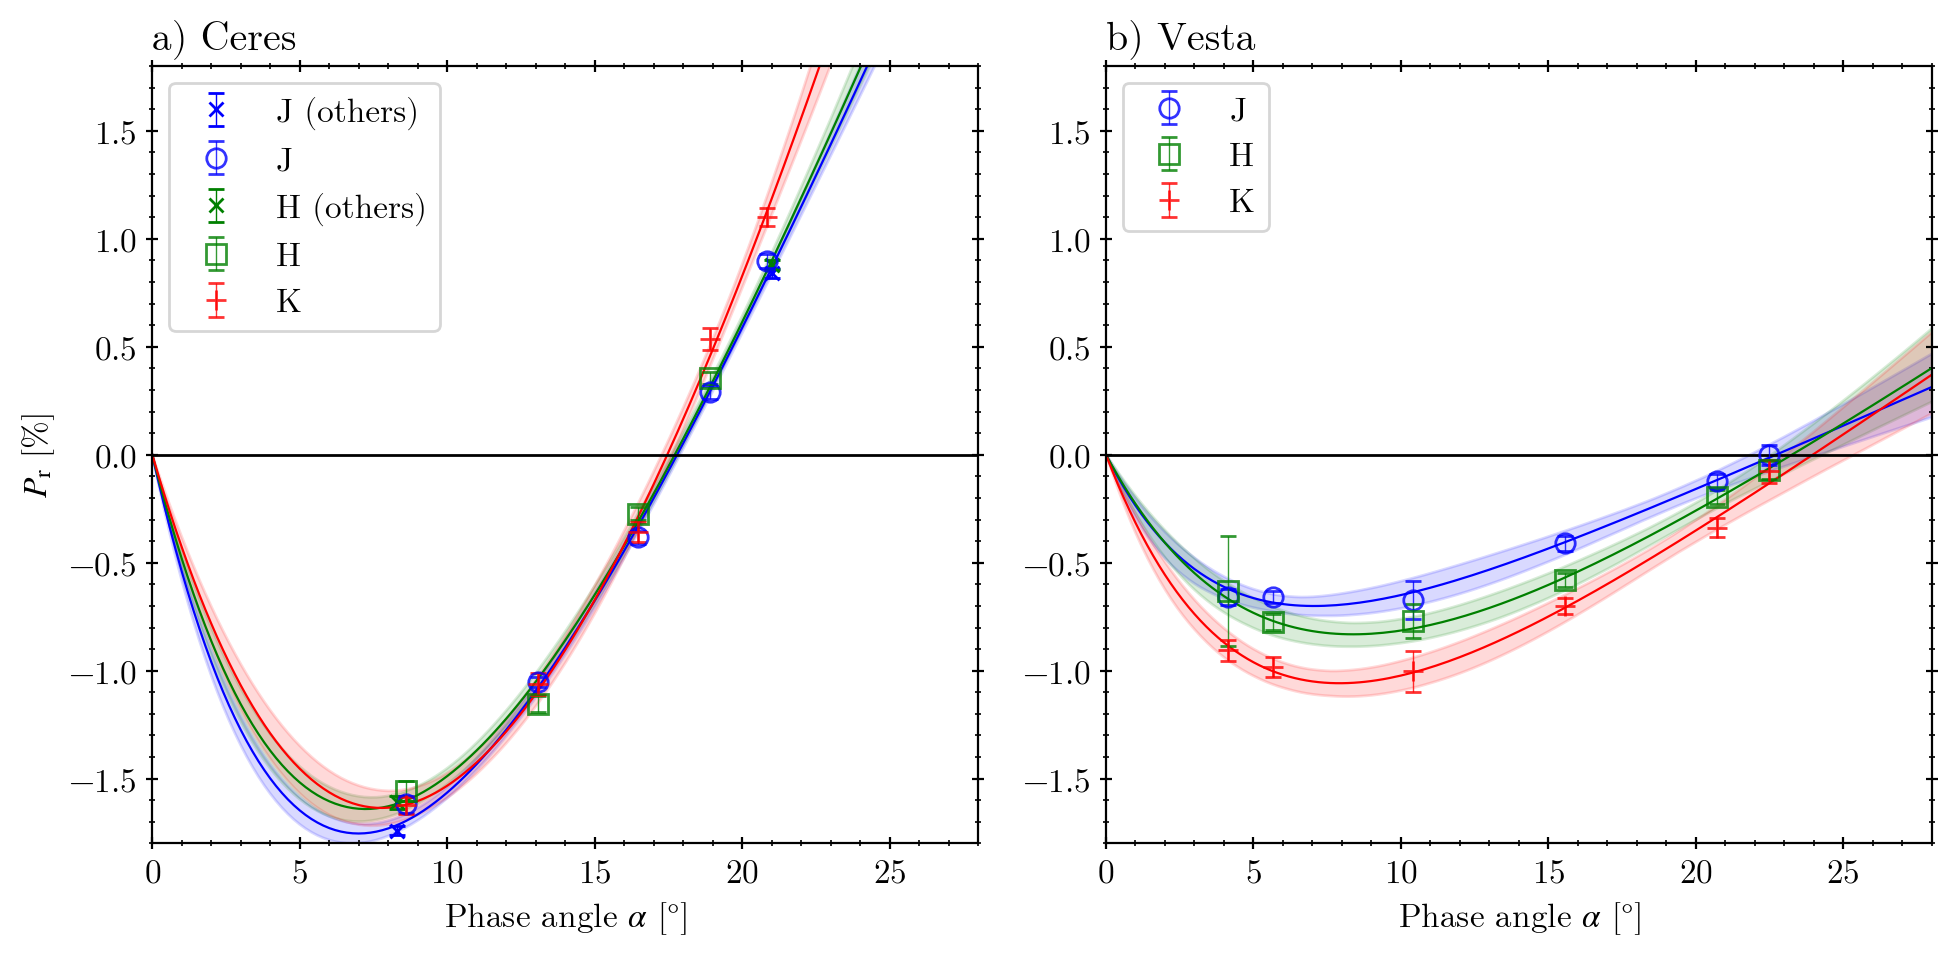

In [8]:
aa = np.arange(0, 40, 0.2)

fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=False, sharey=False, gridspec_kw=None)
for i_obj, obj in enumerate(["Ceres", "Vesta"]):
    ax = axs[i_obj]
    for filt, color, mk in zip("JHK", ["b", "g", "r"], ["o", "s", "+"]):
        _df = df_pol.loc[(df_pol.filt==filt) & (df_pol.objname==obj)]
        alpha = _df["alpha"].to_numpy()
        Pr = _df["Pr"].to_numpy()
        dPr = _df["dPr"].to_numpy()
        popt = popts[obj, filt]
        ax.plot(aa, sbppc.ppc_le(aa, *popt[:3]), color=color, lw=0.8)

        mask = _df["ref"] == "this"
        _kw = dict(color=color, ls="", elinewidth=0.5, mfc="none", capsize=3)
        lab1 = f"{filt} (others)" if np.count_nonzero(~mask) > 0 else None
        ax.errorbar(alpha[~mask], Pr[~mask], yerr=dPr[~mask], **_kw, marker="x", ms=5, label=lab1)
        ax.errorbar(alpha[mask], Pr[mask], yerr=dPr[mask], **_kw, marker=mk, ms=7, alpha=0.8, label=filt, zorder=10)

        _df_mc = samples_masked[obj, filt]
        _df_mc = _df_mc.loc[_df_mc["chi2"] < chi2mins[obj, filt] + chi2.ppf(0.6827, 3)].copy()
        if (minv:= minvals.get((obj, filt))) is None or (maxv := maxvals.get((obj, filt))) is None:
            vals = []
            for pars in _df_mc[["h", "a0", "k"]].values:
                vals.append(sbppc.ppc_le(aa, *pars))
            vals = np.array(vals)
            minv = np.min(vals, axis=0)
            maxv = np.max(vals, axis=0)
            minvals[obj, filt] = minv
            maxvals[obj, filt] = maxv
        ax.fill_between(aa, minv, maxv, alpha=0.15, color=color)
    ax.set(xlim=(0, 28), ylim=(-1.8, 1.8), xlabel=r"Phase angle $α$ [°]")
    ax.set_title(f"{chr(ord('a')+i_obj)}) {obj}", loc="left")
    ax.axhline(0, color="k", lw=1)
    ax.legend(loc=2)
axs[0].set(ylabel=r"$P_\mathrm{r}$ [%]")
plt.tight_layout()
plt.savefig("results/figs-mcmc/ppc.pdf", dpi=300)
plt.show();

APD fit
object   filt   N α_min α_max
Ceres 0.30-0.45 72 1.11 23.08 [ 0.25199104 18.18078613  7.50558319] 7.337609383629621 -1.684241444919735
Ceres 0.45-0.60 58 1.11 23.12 [ 0.25421088 18.23748543  8.11597045] 7.477762949283745 -1.661308233443481
Ceres 0.60-0.75 30 2.71 18.3 [ 0.22907882 18.30196555  6.74147147] 7.194770853846953 -1.6067103454191631
Ceres 0.75-1.00 23 2.71 20.91 [ 0.24843176 18.06672756  8.4935681 ] 7.488495367035817 -1.5799322357894234
Vesta 0.30-0.45 59 5.58 27.72 [ 0.07667142 21.71330663  7.5698646 ] 8.419331097837075 -0.6516566189054279
Vesta 0.45-0.60 57 4.69 27.7 [ 0.06428813 22.19659441  5.91835345] 7.964139036496943 -0.6253037809802922
Vesta 0.60-0.75 25 5.05 27.72 [ 0.06686944 21.76217618  4.06814234] 6.841595188995226 -0.7518422469628093
Vesta 0.75-1.00 13 5.95 24.83 [ 0.06566576 23.30656407  4.19036658] 7.206573747075918 -0.8052262285733556


/var/folders/b1/mdnx6bfn6_v7p70xc3hpc9vh0000gn/T/ipykernel_67811/3782039657.py:54: RuntimeWarning: All-NaN axis encountered
  dy = np.nanmax((_df["dPr"], _df["dpol"]), axis=0)


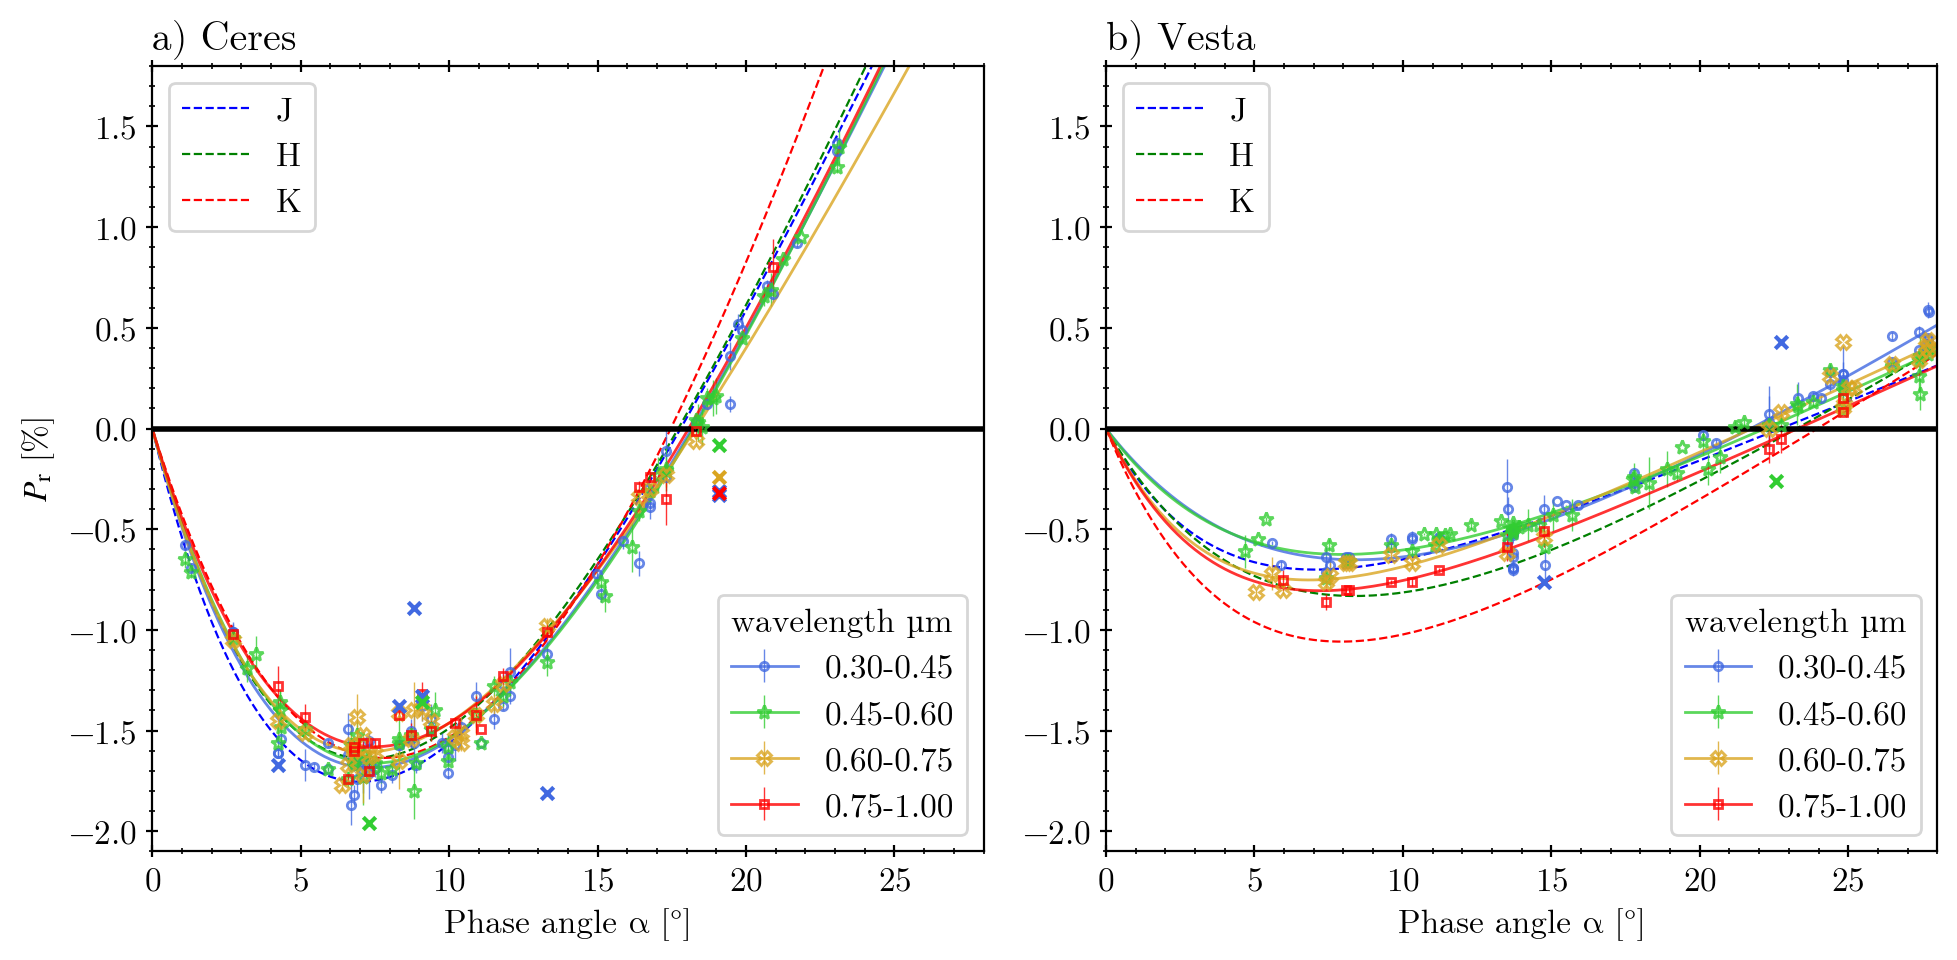

In [12]:
aa = np.arange(0, 40, 0.2)

fig, axs = plt.subplots(1, 2, figsize=(10, 5), sharex=False, sharey=False, gridspec_kw=None)
fit_apd = dict(object=[], filt=[], h=[], a0=[], k=[], amin=[], Pmin=[])
apd_filts = {
    '0.30-0.45': dict(alpha=0.8, capsize=0, marker="o", ms=3, elinewidth=0.5, mfc="none", color="royalblue"),
    '0.45-0.60': dict(alpha=0.8, capsize=0, marker="*", ms=5, elinewidth=0.5, mfc="none", color="limegreen"),
    '0.60-0.75': dict(alpha=0.8, capsize=0, marker="X", ms=5, elinewidth=0.5, mfc="none", color="goldenrod"),
    '0.75-1.00': dict(alpha=0.8, capsize=0, marker="s", ms=3, elinewidth=0.5, mfc="none", color="r"),
}

errb_kw = dict(alpha=1, capsize=0, ms=4, elinewidth=0.5, mfc="none")

print("APD fit\nobject   filt   N α_min α_max")
for i_objname, objname in enumerate(["Ceres", "Vesta"]):
    ax = axs[i_objname]
    ax_apd = ax.twinx()
    ax_apd.axis("off")
    for filt, color in zip("JHK", ["b", "g", "r"]):
        _df = df_pol.loc[(df_pol.filt==filt) & (df_pol.objname==objname)]
        dof = (len(_df) - ppc.npars)
        alpha = _df["alpha"].to_numpy()
        Pr = _df["Pr"].to_numpy()
        dPr = _df["dPr"].to_numpy()
        popt = popts[objname, filt]
        ax.plot(aa, sbppc.ppc_le(aa, *popt[:3]), ls="--", color=color, lw=0.8, label=filt)

        mask = _df["ref"] == "this"
        _kw = dict(color=color, ls="", elinewidth=0.5, mfc="none", capsize=3)
        lab1 = f"{filt} (others)" if np.count_nonzero(~mask) > 0 else None
        # ax.errorbar(alpha[~mask], Pr[~mask], yerr=dPr[~mask], **_kw, marker="o", ms=8, label=lab1)
        # ax.errorbar(alpha[mask], Pr[mask], yerr=dPr[mask], **_kw, marker="*", ms=10, alpha=0.8, label=filt)

        # if (minv:= minvals.get((objname, filt))) is None or (maxv := maxvals.get((objname, filt))) is None:
        #     vals = []
        #     for pars in _df_mc[["h", "a0", "k"]].values:
        #         vals.append(sbppc.ppc_le(aa, *pars))
        #     vals = np.array(vals)
        #     minv = np.min(vals, axis=0)
        #     maxv = np.max(vals, axis=0)
        #     minvals[objname, filt] = minv
        #     maxvals[objname, filt] = maxv
        # ax.fill_between(aa, minv, maxv, alpha=0.2, color=color)

    _apd = df_apd.loc[(df_apd["name"] == objname)].copy()
    _apd = _apd.sort_values('wlen')
    _apd_uv = _apd[_apd['wlen'] < 0.45]
    _apd_vis = _apd[(0.45 < _apd['wlen']) & (_apd['wlen'] < 0.60)]
    _apd_red = _apd[(0.60 < _apd['wlen']) & (_apd['wlen'] < 0.75)]
    _apd_ir = _apd[(0.75 < _apd['wlen']) & (_apd['wlen'] < 1.0)]
    for i, (_df, (name, kw)) in enumerate(zip([_apd_uv, _apd_vis, _apd_red, _apd_ir],
                                                 apd_filts.items())):
        x, y = _df["alpha"].to_numpy(), _df["Pr"].to_numpy()
        dy = np.nanmax((_df["dPr"], _df["dpol"]), axis=0)
        # dy = _df["dpol"].to_numpy()
        finite = np.isfinite(x) & np.isfinite(y) & ((np.isnan(dy) | (dy < 0.15)))
#         finite = np.isfinite(x) & np.isfinite(y) & np.isfinite(dy)
        x, y, dy = x[finite], y[finite], dy[finite]
        # dy[(np.isnan(dy))] = 0.15
        # dy[dy < 0.05] = 0.05
        _ppc = sbppc.PPCModel("le")
        _ppc.solve_lsq(x, y, yerr=None)
        _resid = (y - _ppc.fun_lsq(x))
        _mask = np.abs(_resid) > 0.25 #(_resid == np.nanmax(_resid))
        ax.scatter(x[_mask], y[_mask], marker="x", color=kw["color"], s=20, zorder=10)
        x, y, dy = x[~_mask], y[~_mask], dy[~_mask]
        _ppc.solve_lsq(x, y, yerr=None)

        ax.errorbar(x, y, yerr=dy, ls="", **kw)
        ax_apd.errorbar([np.nan], [np.nan], yerr=np.nan, **kw, lw=1, ls="-",  label=f"{name}")
        for k, v in zip(fit_apd.keys(), [objname, name, *_ppc.theta_lsq, _ppc.amin_lsq, _ppc.pmin_lsq]):
            fit_apd[k].append(v)
        print(objname, name, len(dy), x.min(), x.max(), _ppc.theta_lsq, _ppc.amin_lsq, _ppc.pmin_lsq)
        ax.plot(aa, _ppc.fun_lsq(aa), color=kw["color"], lw=1, ls="-", alpha=kw["alpha"])

    ax.legend(loc=2)
    ax.set(
        xlabel="Phase angle α [°]",
        # ylabel=r"$P_\mathrm{r}$ [%]",
        xlim=(0, 28),
        ylim=(-2.1, 1.8),
    )
    ax.set_title(f"{chr(ord('a')+i_objname)}) {objname}", loc="left")
    ax.axhline(0, color="k", lw=2)
    ax_apd.legend(loc=4, title=r"wavelength µm")
axs[0].set(ylabel=r"$P_\mathrm{r}$ [%]")

plt.tight_layout()
plt.savefig("results/figs-mcmc/ppc+apd.pdf", dpi=300)
plt.show();

In [13]:
fit_apd = pd.DataFrame.from_dict(fit_apd)
df_fit_all = pd.concat([df_fit, fit_apd])
wlen = df_fit_all["filt"].map({'0.30-0.45':0.4, '0.45-0.60':0.5, '0.60-0.75':0.65, '0.75-1.00': 0.9,
                               'H':1.632, 'J':1.253, 'K':2.146})
df_fit_all.insert(loc=2, value=wlen, column="wlen")
df_fit_all = df_fit_all.sort_values(["object", "wlen"]).reset_index(drop=True)

## Umow's Law

For the albedo (r = reflectance from SMASS, r(0.55) = reflectance at 0.55 µm, A(0.55) = geometric albedo at 0.55 µm, f = filter profile):

$$
A = \frac{\int \frac{r(λ)}{r(0.55)} A(0.55) f(λ) dλ }{\int f(λ) dλ}
  = \frac{A(0.55)}{r(0.55)} \frac{\int r(λ) f(λ) dλ }{\int f(λ) dλ}
$$

Assume Δr(0.55) = 0 and no uncertainty in filter profile.

$$
ΔA = \sqrt{ \left( ΔA(0.55) \frac{\int r(λ)/r(0.55) f(λ) dλ }{\int f(λ) dλ} \right)^2
            + \left( A(0.55) \frac{\int Δr(λ)/r(0.55) f(λ) dλ }{\int f(λ) dλ} \right)^2}
$$

or

$$
ΔA = A \sqrt{ \left( \frac{dA(0.55)}{A(0.55)} \right)^2 + \left( \frac{\int Δr(λ)/r(0.55) f(λ) dλ}{\int r(λ)/r(0.55) f(λ) dλ} \right)^2}
$$

In the code, I intentionally set the filter of "0.30-0.45" to give nan value, because the VIS-NIR reflectance does not cover this region properly.

In [15]:
# wavelength	u204_J252-1	u209_H105D	u213_K322A

# CiarnielloM+2017_AnA_598_130 0.55 µm geometric albedo for Ceres(0.094 ± 0.007)
# LiJY+2013_Icar_226_1252 554nm geometric albedo for Vesta (0.38 ± 0.04)
albs_5500 = dict(Ceres=0.094, Vesta=0.38)
dalbs_5500 = dict(Ceres=0.007, Vesta=0.04)

df_fit_all["alb"] = None
df_fit_all["dalb"] = None

l_filt = df_filt["wavelength"] / 1000  # in um
f_filt = {
    '0.30-0.45': lambda wlen: 100*(np.heaviside(wlen-0.30-0.01, 0) - np.heaviside(wlen-0.45+0.01, 0)),
    '0.45-0.60': lambda wlen: 100*(np.heaviside(wlen-0.45-0.01, 0) - np.heaviside(wlen-0.60+0.01, 0)),
    '0.60-0.75': lambda wlen: 100*(np.heaviside(wlen-0.60-0.01, 0) - np.heaviside(wlen-0.75+0.01, 0)),
    '0.75-1.00': lambda wlen: 100*(np.heaviside(wlen-0.75-0.01, 0) - np.heaviside(wlen-1.00+0.01, 0)),
    "J":interp1d(l_filt, df_filt["u204_J252-1"], bounds_error=False, fill_value=0),
    "H":interp1d(l_filt, df_filt["u209_H105D"], bounds_error=False, fill_value=0),
    "K":interp1d(l_filt, df_filt["u213_K322A"], bounds_error=False, fill_value=0)
}  # filter profiles


for i, row in df_fit_all.iterrows():
    objname = row["object"]
    filt = row["filt"]
    _filt_fun = f_filt[filt]
    _df = df_refl_ceres if objname == "Ceres" else df_refl_vesta
    r_5500 = _df.loc[_df["wlen"]==0.55].iloc[0]["r"]
    refl = _df["r"]/r_5500  # normalize to 0.55
    drefl = _df["dr"]/r_5500  # normalize to 0.55
    a_5500 = albs_5500[objname]
    da_5500 = dalbs_5500[objname]

    filter_prof = _filt_fun(_df["wlen"])
    dx = np.ediff1d(_df["wlen"])
    int_f = trapezoid(filter_prof, _df["wlen"], dx=dx)
    int_refl_f = trapezoid(filter_prof*refl, _df["wlen"], dx=dx)
    int_drefl_f = trapezoid(filter_prof*drefl, _df["wlen"], dx=dx)
    _alb = a_5500*int_refl_f/int_f
    _dalb = _alb*np.sqrt((da_5500/a_5500)**2 + (int_drefl_f/int_refl_f)**2)
    if not np.isnan(_alb):
        filt = r"\Ks" if filt=="K" else filt.replace("-", r"\thru")
        if _alb < 0.1:
            print(f"{objname} & {filt} & {_alb:.4f} & {_dalb:.4f}\\\\")
        else:
            print(f"{objname} & {filt} & {_alb:.3f} & {_dalb:.3f}\\\\")

    df_fit_all.at[i, "alb"] = _alb
    df_fit_all.at[i, "dalb"] = _dalb

Ceres & 0.30\thru0.45 & 0.0867 & 0.0066\\
Ceres & 0.45\thru0.60 & 0.0931 & 0.0069\\
Ceres & 0.60\thru0.75 & 0.0957 & 0.0071\\
Ceres & 0.75\thru1.00 & 0.0943 & 0.0070\\
Ceres & J & 0.0897 & 0.0067\\
Ceres & H & 0.0921 & 0.0069\\
Ceres & \Ks & 0.0942 & 0.0070\\
Vesta & 0.45\thru0.60 & 0.372 & 0.039\\
Vesta & 0.60\thru0.75 & 0.403 & 0.042\\
Vesta & 0.75\thru1.00 & 0.322 & 0.034\\
Vesta & J & 0.450 & 0.047\\
Vesta & H & 0.434 & 0.046\\
Vesta & \Ks & 0.404 & 0.043\\


/var/folders/b1/mdnx6bfn6_v7p70xc3hpc9vh0000gn/T/ipykernel_67811/307171750.py:39: RuntimeWarning: invalid value encountered in scalar divide
  _alb = a_5500*int_refl_f/int_f
/var/folders/b1/mdnx6bfn6_v7p70xc3hpc9vh0000gn/T/ipykernel_67811/307171750.py:40: RuntimeWarning: invalid value encountered in scalar divide
  _dalb = _alb*np.sqrt((da_5500/a_5500)**2 + (int_drefl_f/int_refl_f)**2)


In [ ]:
df_fit_all.to_csv("results/df_fit_all.csv", index=False)